# Example 3: Tile2Vec features for CDL classification
In this notebook, we'll use a Tile2Vec model that has been pre-trained on the NAIP dataset to embed a small NAIP dataset and then train a classifier on the corresponding Cropland Data Layer (CDL) labels.

In [1]:
import numpy as np
import os
import torch
from time import time
from torch.autograd import Variable

import sys
sys.path.append('../')
from src.tilenet import make_tilenet
from src.resnet import ResNet18

## Step 1. Loading pre-trained model
In this step, we will initialize a new TileNet model and then load the pre-trained weights.

In [2]:
# Setting up model
in_channels = 4
z_dim = 512
cuda = torch.cuda.is_available()
# tilenet = make_tilenet(in_channels=in_channels, z_dim=z_dim)
# Use old model for now
tilenet = ResNet18()
if cuda: tilenet.cuda()

In [3]:
# Load parameters

#Requires pre downloading the trained model from the convnet.
#model_fn = '../models/naip_trained.ckpt'
model_fn = "../models/strat1ht1_ep10.ckpt" #open file
#model_fn = '../models/testing_run.ckpt'
#checkpoint = torch.load(model_fn)
tilenet.load_state_dict(torch.load(model_fn), strict=False)
#tilenet.load_state_dict(checkpoint)
tilenet.eval()

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

## Step 2. Embed NAIP tiles
In this step, we'll use TileNet to embed the NAIP tiles provided in `tile2vec/data/tiles`. There are 1000 tiles in total, named `1tile.npy` through `1000tile.npy`.

In [4]:
# Get data
tile_dir = '../data/tiles'
n_tiles = 1000
y = np.load(os.path.join(tile_dir, 'y.npy'))
print(y.shape)

(1000,)


In [30]:
# Embed tiles
t0 = time()
X = np.zeros((n_tiles, z_dim))
beforeEmbed = np.zeros((n_tiles,50,50,4))

for idx in range(n_tiles):
    tile = np.load(os.path.join(tile_dir, '{}tile.npy'.format(idx+1)))
    # Get first 4 NAIP channels (5th is CDL mask)
    tile = tile[:,:,:4]
    tile = tile/255
    beforeEmbed[idx,:,:,:] = tile
    # Rearrange to PyTorch order
    tile = np.moveaxis(tile, -1, 0)
    tile = np.expand_dims(tile, axis=0)
    # Scale to [0, 1]
    #tile = tile / 255
    
    # Embed tile
    tile = torch.from_numpy(tile).float()
    tile = Variable(tile)
    if cuda: tile = tile.cuda()
    z = tilenet.encode(tile)
    if cuda: z = z.cpu()
    z = z.data.numpy() #1 by 512
    X[idx,:] = z
t1 = time()

print(X.shape)
print(beforeEmbed.shape)
print('Embedded {} tiles: {:0.3f}s'.format(n_tiles, t1-t0))

(1000, 512)
(1000, 50, 50, 4)
Embedded 1000 tiles: 12.073s


In [31]:
Z = X
patches = beforeEmbed
#print(y)

In [32]:
mapping = {0: "Background", 1: "Corn", 2: "Cotton", 3: "Rice", 4: "Sorghum", 5: "Soybeans", 6: "Sunflower", 10: "Peanuts", 11: "Tobacco", 12: "Sweet Corn", 13: "Pop or Orn Corn", 14: "Mint", 21: "Barley", 22: "Durum Wheat", 23: "Spring Wheat", 24: "Winter Wheat", 25: "Other Small Grains", 26: "Dbl Crop WinWht/Soybeans", 27: "Rye", 28: "Oats", 29: "Millet", 30: "Speltz", 31: "Canola", 32: "Flaxseed", 33: "Safflower", 34: "Rape Seed", 35: "Mustard", 36: "Alfalfa", 37: "Other Hay/Non Alfalfa", 38: "Camelina", 39: "Buckwheat", 41: "Sugarbeets", 42: "Dry Beans", 43: "Potatoes", 44: "Other Crops", 45: "Sugarcane", 46: "Sweet Potatoes", 47: "Misc Vegs & Fruits", 48: "Watermelons", 49: "Onions", 50: "Cucumbers", 51: "Chick Peas", 52: "Lentils", 53: "Peas", 54: "Tomatoes", 55: "Caneberries", 56: "Hops", 57: "Herbs", 58: "Clover/Wildflowers", 59: "Sod/Grass Seed", 60: "Switchgrass", 61: "Fallow/Idle Cropland", 63: "Forest", 64: "Shrubland", 65: "Barren", 66: "Cherries", 67: "Peaches", 68: "Apples", 69: "Grapes", 70: "Christmas Trees", 71: "Other Tree Crops", 72: "Citrus", 74: "Pecans", 75: "Almonds", 76: "Walnuts", 77: "Pears", 81: "Clouds/No Data", 82: "Developed", 83: "Water", 87: "Wetlands", 88: "Nonag/Undefined", 92: "Aquaculture", 111: "Open Water", 112: "Perennial Ice/Snow", 121: "Developed/Open Space", 122: "Developed/Low Intensity", 123: "Developed/Med Intensity", 124: "Developed/High Intensity", 131: "Barren", 141: "Deciduous Forest", 142: "Evergreen Forest", 143: "Mixed Forest", 152: "Shrubland", 176: "Grassland/Pasture", 190: "Woody Wetlands", 195: "Herbaceous Wetlands", 204: "Pistachios", 205: "Triticale", 206: "Carrots", 207: "Asparagus", 208: "Garlic", 209: "Cantaloupes", 210: "Prunes", 211: "Olives", 212: "Oranges", 213: "Honeydew Melons", 214: "Broccoli", 216: "Peppers", 217: "Pomegranates", 218: "Nectarines", 219: "Greens", 220: "Plums", 221: "Strawberries", 222: "Squash", 223: "Apricots", 224: "Vetch", 225: "Dbl Crop WinWht/Corn", 226: "Dbl Crop Oats/Corn", 227: "Lettuce", 229: "Pumpkins", 230: "Dbl Crop Lettuce/Durum Wht", 231: "Dbl Crop Lettuce/Cantaloupe", 232: "Dbl Crop Lettuce/Cotton", 233: "Dbl Crop Lettuce/Barley", 234: "Dbl Crop Durum Wht/Sorghum", 235: "Dbl Crop Barley/Sorghum", 236: "Dbl Crop WinWht/Sorghum", 237: "Dbl Crop Barley/Corn", 238: "Dbl Crop WinWht/Cotton", 239: "Dbl Crop Soybeans/Cotton", 240: "Dbl Crop Soybeans/Oats", 241: "Dbl Crop Corn/Soybeans", 242: "Blueberries", 243: "Cabbage", 244: "Cauliflower", 245: "Celery", 246: "Radishes", 247: "Turnips", 248: "Eggplants", 249: "Gourds", 250: "Cranberries", 254: "Dbl Crop Barley/Soybeans"}
print(mapping.values())

dict_values(['Background', 'Corn', 'Cotton', 'Rice', 'Sorghum', 'Soybeans', 'Sunflower', 'Peanuts', 'Tobacco', 'Sweet Corn', 'Pop or Orn Corn', 'Mint', 'Barley', 'Durum Wheat', 'Spring Wheat', 'Winter Wheat', 'Other Small Grains', 'Dbl Crop WinWht/Soybeans', 'Rye', 'Oats', 'Millet', 'Speltz', 'Canola', 'Flaxseed', 'Safflower', 'Rape Seed', 'Mustard', 'Alfalfa', 'Other Hay/Non Alfalfa', 'Camelina', 'Buckwheat', 'Sugarbeets', 'Dry Beans', 'Potatoes', 'Other Crops', 'Sugarcane', 'Sweet Potatoes', 'Misc Vegs & Fruits', 'Watermelons', 'Onions', 'Cucumbers', 'Chick Peas', 'Lentils', 'Peas', 'Tomatoes', 'Caneberries', 'Hops', 'Herbs', 'Clover/Wildflowers', 'Sod/Grass Seed', 'Switchgrass', 'Fallow/Idle Cropland', 'Forest', 'Shrubland', 'Barren', 'Cherries', 'Peaches', 'Apples', 'Grapes', 'Christmas Trees', 'Other Tree Crops', 'Citrus', 'Pecans', 'Almonds', 'Walnuts', 'Pears', 'Clouds/No Data', 'Developed', 'Water', 'Wetlands', 'Nonag/Undefined', 'Aquaculture', 'Open Water', 'Perennial Ice/Snow

In [84]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import offsetbox
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter

# Figure A6

# Z is an array of all the embeddings, dimension (n, 512)
# y is an array of all the labels, dimension (n,)
# patches is an array of all the tiles, dimension (n, 50, 50, 4)
# we filtered Z and y to contain only the top 10 CDL classes for this visualization

# PCA on embeddings (pre-TSNE processing)
n_pca = 20
t0 = time()
Z_pca = PCA(n_pca).fit_transform(Z)
print('PCA: {}, {:0.3f}s'.format(Z_pca.shape, time()-t0))

def produce_tsne_plot(n_trials, init='pca', label_size=25):
    for _ in range(n_trials):
        # Randomly sample subset
        n_sample = 1000
        idxs = np.random.choice(range(len(y)), size=n_sample, replace=False)
        Z_sample = Z_pca[idxs]
        y_sample = y[idxs]
        
        p_sample = [patches[idx] for idx in idxs]

        # TSNE on random sample of PCA of embeddings
        n_tsne = 2
        Z_tsne = TSNE(n_tsne, init=init).fit_transform(Z_sample)

        # Plot TSNE embeddings with color
        scale = 12
        figsize = (2.25*scale, 1*scale)
        axis_offset = 0.025
        # Patch embedding parameters
        fs_labels = 14
        min_dist = 3e-3
        cbar_labels = [class_name for idx, class_name in mapping.items()]
        top_k = 10
        # CDL label parameters
        cm = ListedColormap(sns.color_palette('hls', top_k))
        marker_size = 100

        # Plot patch embeddings
        fig, (ax1, ax2, cax) = plt.subplots(ncols=3, figsize=figsize,
            gridspec_kw={"width_ratios":[1, 1, 0.05]})
        x_min, x_max = np.min(Z_tsne, 0), np.max(Z_tsne, 0)
        X = (Z_tsne - x_min) / (x_max - x_min)
        shown_patches = np.array([[1, 1]])
        for i in range(X.shape[0]):
            # Don't plot images too close in embedding space
            dist = np.sum((X[i] - shown_patches) ** 2, 1)
            if np.min(dist) < min_dist: continue
            # Add patch to display
            img = p_sample[i][:,:,:3]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img),
                X[i], frameon=False)
            ax1.add_artist(imagebox)
        ax1.set_xlim([-axis_offset, 1+axis_offset])
        ax1.set_ylim([-axis_offset, 1+axis_offset])
        ax1.axis('off')

        # Plot CDL labels
        x_min, x_max = np.min(Z_tsne, 0), np.max(Z_tsne, 0)
        X = (Z_tsne - x_min) / (x_max - x_min)
        im = ax2.scatter(X[:,0], X[:,1], c=y_sample, cmap=cm, s=marker_size)
        ax2.set_xlim([-axis_offset, 1+axis_offset])
        ax2.set_ylim([-axis_offset, 1+axis_offset])
        ax2.axis('off')
        # Colorbar stuff
        cbar = fig.colorbar(im, cax=cax, spacing='proportional')
        print(cbar_labels)
        cbar.set_ticks([22*idx for idx in range(10)])
        cbar.ax.set_yticklabels(cbar_labels, size=label_size)
        cbar.ax.invert_yaxis()
        
        

        plt.show()

PCA: (1000, 20), 0.036s


['Background', 'Corn', 'Cotton', 'Rice', 'Sorghum', 'Soybeans', 'Sunflower', 'Peanuts', 'Tobacco', 'Sweet Corn', 'Pop or Orn Corn', 'Mint', 'Barley', 'Durum Wheat', 'Spring Wheat', 'Winter Wheat', 'Other Small Grains', 'Dbl Crop WinWht/Soybeans', 'Rye', 'Oats', 'Millet', 'Speltz', 'Canola', 'Flaxseed', 'Safflower', 'Rape Seed', 'Mustard', 'Alfalfa', 'Other Hay/Non Alfalfa', 'Camelina', 'Buckwheat', 'Sugarbeets', 'Dry Beans', 'Potatoes', 'Other Crops', 'Sugarcane', 'Sweet Potatoes', 'Misc Vegs & Fruits', 'Watermelons', 'Onions', 'Cucumbers', 'Chick Peas', 'Lentils', 'Peas', 'Tomatoes', 'Caneberries', 'Hops', 'Herbs', 'Clover/Wildflowers', 'Sod/Grass Seed', 'Switchgrass', 'Fallow/Idle Cropland', 'Forest', 'Shrubland', 'Barren', 'Cherries', 'Peaches', 'Apples', 'Grapes', 'Christmas Trees', 'Other Tree Crops', 'Citrus', 'Pecans', 'Almonds', 'Walnuts', 'Pears', 'Clouds/No Data', 'Developed', 'Water', 'Wetlands', 'Nonag/Undefined', 'Aquaculture', 'Open Water', 'Perennial Ice/Snow', 'Develope

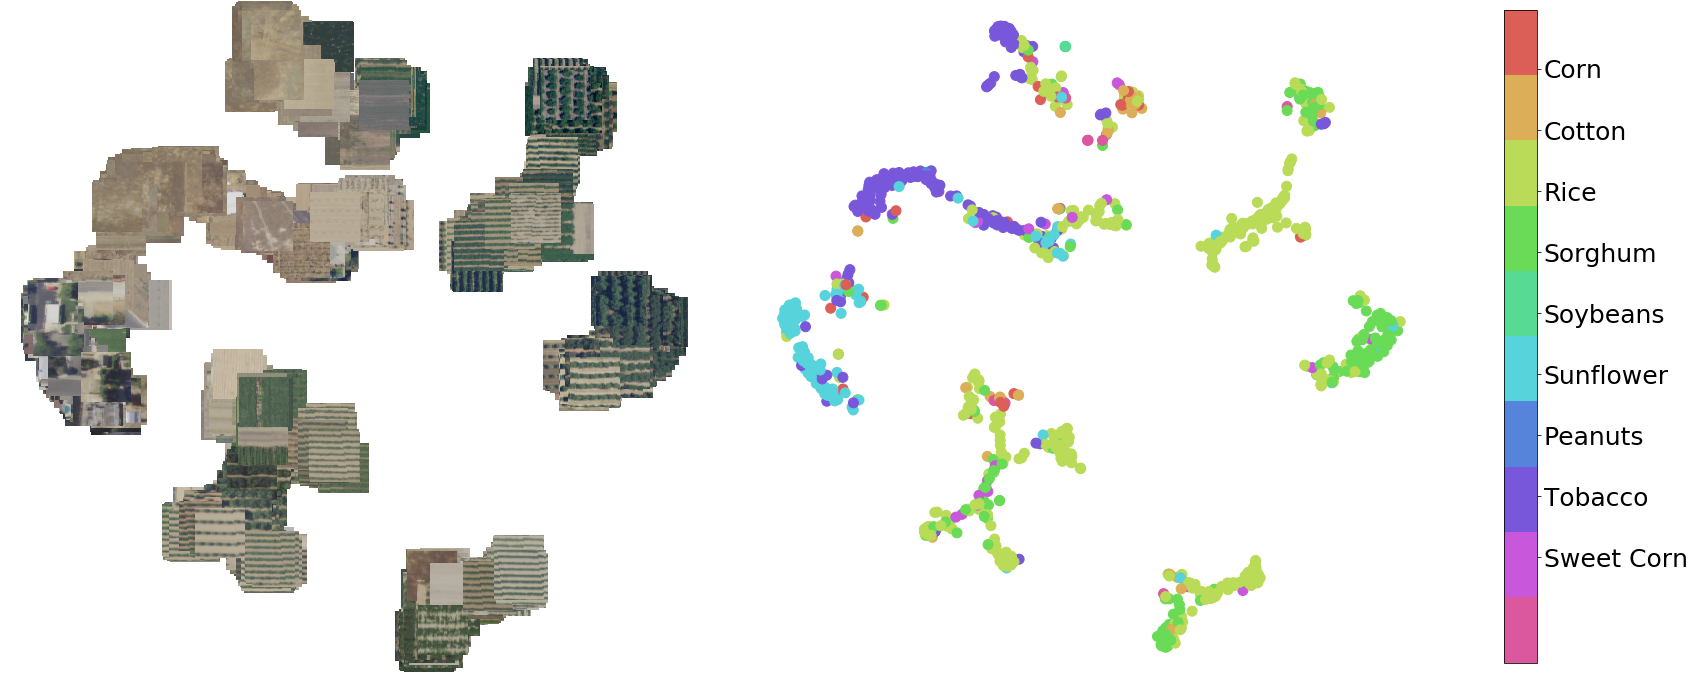

In [85]:
produce_tsne_plot(1)

## Step 3. Train random forest classifier
In this step, we'll split the dataset into train and test sets and train a random forest classifier to predict CDL classes.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Check CDL classes
print(set(y))

In [ ]:
#Making sure all of our classifications are correct (Checks out correctly)
index = 874

for i in range(1000):
    file_ = "../data/tiles/"+str(i+1)+"tile.npy"
    tile = np.load(file_)
    counts_anchor = np.bincount(tile[:,:,4].reshape(2500,))
    anchor_label = np.argmax(counts_anchor)
    actual = y[i]
    if actual != anchor_label:
        print(i)
print("Ended")


Since the CDL classes are not numbered in consecutive order, we'll start by reindexing the classes from 0.

In [ ]:
# Reindex CDL classes
y = LabelEncoder().fit_transform(y)
print(set(y))

We can randomly split the data and train a random forest classifier many times to get an estimate of the average accuracy.

In [ ]:
n_trials = 100
accs = np.zeros((n_trials,))
for i in range(n_trials):
    # Splitting data and training RF classifer
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
    rf = RandomForestClassifier()
    rf.fit(X_tr, y_tr) #X-tr is 512 by 1
    accs[i] = rf.score(X_te, y_te)
print('Mean accuracy: {:0.4f}'.format(accs.mean()))
print('Standard deviation: {:0.4f}'.format(accs.std()))